## Loading Libraries 

In [1]:
import re
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer, util, losses, InputExample, evaluation
from datetime import datetime
import os
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
import jellyfish

%matplotlib inline

D:\Anaconda3\lib\site-packages\transformers\utils\generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
D:\Anaconda3\lib\site-packages\transformers\utils\generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
D:\Anaconda3\lib\site-packages\transformers\utils\generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
df = pd.read_json('test_ans.json')
df

,id,text,label,extracted_part_text,extracted_part_answer_start,extracted_part_answer_end
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта,,0,0
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Обеспечение исполнения контракта,1215,1247
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта,Обеспечение исполнения настоящего,1679,1712
3,274660397,Идентификационный код закупки: 222631202689463...,обеспечение исполнения контракта,Обеспечение исполнения настоящего,1691,1724
4,732742591,Идентификационный код закупки: 222637800031163...,обеспечение исполнения контракта,Обеспечение исполнения настоящего,1693,1726
...,...,...,...,...,...,...
313,854936033,ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯ...,обеспечение гарантийных обязательств,,0,0
314,576390745,Часть III Проект договора Договор №______ пост...,обеспечение гарантийных обязательств,Возврат обеспечения гарантийных обязательств п...,2372,2425
315,323745820,УТВЕРЖДАЮ Председатель единой комиссии по осущ...,обеспечение гарантийных обязательств,,0,0
316,712286194,Версия с 04.07.2022 года У Т В Е Р Ж Д А Ю «Го...,обеспечение гарантийных обязательств,,0,0


In [3]:
df.replace('', np.nan, inplace = True)
df

,id,text,label,extracted_part_text,extracted_part_answer_start,extracted_part_answer_end
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта,NaN,0,0
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Обеспечение исполнения контракта,1215,1247
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта,Обеспечение исполнения настоящего,1679,1712
3,274660397,Идентификационный код закупки: 222631202689463...,обеспечение исполнения контракта,Обеспечение исполнения настоящего,1691,1724
4,732742591,Идентификационный код закупки: 222637800031163...,обеспечение исполнения контракта,Обеспечение исполнения настоящего,1693,1726
...,...,...,...,...,...,...
313,854936033,ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯ...,обеспечение гарантийных обязательств,NaN,0,0
314,576390745,Часть III Проект договора Договор №______ пост...,обеспечение гарантийных обязательств,Возврат обеспечения гарантийных обязательств п...,2372,2425
315,323745820,УТВЕРЖДАЮ Председатель единой комиссии по осущ...,обеспечение гарантийных обязательств,NaN,0,0
316,712286194,Версия с 04.07.2022 года У Т В Е Р Ж Д А Ю «Го...,обеспечение гарантийных обязательств,NaN,0,0


## Checking if there are any null values in the dataframe

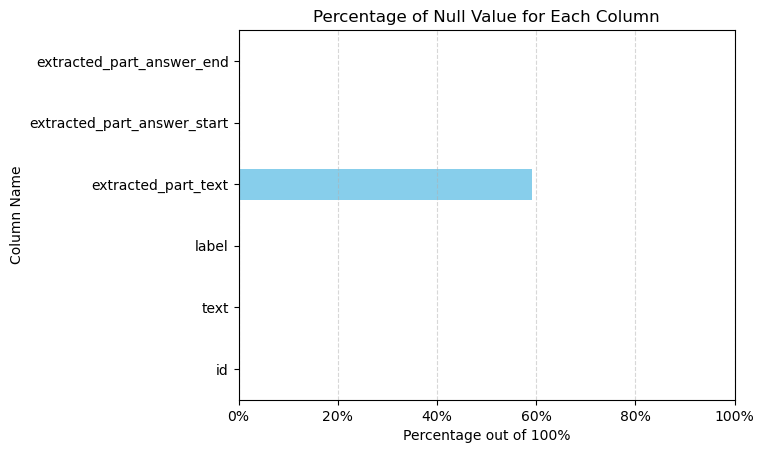

In [4]:
null_percentage = df.isnull().mean()*100

x_ticks = [0,20,40,60,80,100]
null_percentage.plot(kind='barh', color='skyblue')
plt.title('Percentage of Null Value for Each Column')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlabel('Percentage out of 100%')
plt.ylabel('Column Name')
plt.xticks(x_ticks, [f'{i}%' for i in x_ticks])
plt.xlim(0,100)
plt.show()

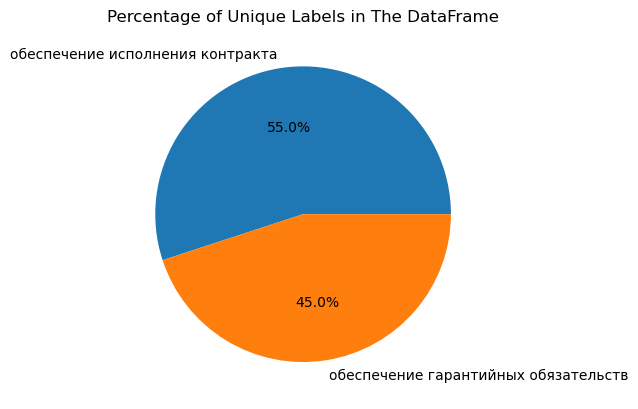

In [5]:
plt.pie(df['label'].value_counts(), labels=df['label'].unique(), autopct='%1.1f%%')
plt.title('Percentage of Unique Labels in The DataFrame')
plt.show()

## Text Preprocessing

In [6]:
def expand_abbreviations(text):

    """
    Expand abbreviations in a given text string based on predefined mapping rules.

    This function replaces common abbreviations found within the text with their full forms.
    The replacements are case-sensitive, and ensure that the word following the abbreviation is in lowercase.

    Parameters:
    - text (str): The text in which abbreviations need to be expanded.

    Returns:
    - str: The text with abbreviations expanded.

    The abbreviations and their expansions are stored in a dictionary. Each key in this dictionary
    is an abbreviation, and its corresponding value is the full form. The function iterates through
    each abbreviation, searches for it followed by a space and a word character, and replaces it
    with its full form followed by the word in lowercase. This is done using a regular expression
    that matches the abbreviation followed by any subsequent word characters, ensuring that the
    abbreviation is isolated and not part of another word.

    Example:
    >>> expand_abbreviations("ул. Пушкина")
    'улица пушкина'
    """

    # Dictionary of abbreviations (extracted depending on data exploration)
    abbv = dict({'ул.':'улица',
                 'г.':'город',
                 'пр.':'город',
                 'ст.':'статья',
                 'ч.':'часть'})

    for key, value in abbv.items():
        pattern = re.compile(re.escape(key) + r'\s(\w+)')
        # sub finds and replaces matches with the value and lower the second captured group which is the word after the key
        # this replacement is implemented on the text variable
        text = pattern.sub(lambda match: f'{value} {match.group(1).lower()}', text)
    return text


def detect_numbering(text):

    """
    Detects and modifies numbered lists in a string, accounting for nested parenthetical expressions.

    This function searches through the provided text for numbering patterns such as '2.', '1.1.', or '2.1.1)'
    and adjusts them ensuring they are not within nested parentheses. It handles formatting by ensuring each detected
    numbering sequence begins on a new line and is followed by a correctly capitalized word.

    Parameters:
    - text (str): The input text containing potential numbering sequences.

    Returns:
    - str: The modified text with numbering sequences formatted and positioned.

    The function uses a regular expression pattern to identify valid numbering sequences and checks whether these sequences are within
    nested parentheses by tracking the depth of nesting. If a numbering sequence is found outside of any nested parentheses, its position
    is recorded. The text is then modified to ensure that each numbering sequence starts on a new line and the first word following the
    sequence is capitalized if necessary.

    Example:
    >>> detect_numbering("Here is a list: (1. First item, 2. Second item), and outside the list 1. New item")
    'Here is a list: (1. First item, 2. Second item), and outside the list\n1. New item'
    """

    # character pointer
    i = 0
    
    # Tracks the depth of the nested parantheses
    depth = 0
    
    # List to store the tuple (start, end) indices of the valid numbering system matches that are outside the nested parantheses, so it is considered valid
    valid_numbering_positions = []
    
    # Pattern to find numbering systems like '2.', '1.1.', '1.1.1.', '2)', '2.1)', or '2.1.1)'.
    numbering_pattern = re.compile(r'\b(\d+(\.\d+)*[\.)])(?=\s|$|\n)') # \b indicates new word

    while i < len(text):
        # if the character is '(': increment the depth by 1 which indicates a new level of nesting
        if text[i] == '(':
            depth += 1

        # if character is ')' and depth > 0: decrement the depth by 1 which indicates exiting the current nesting level
        elif text[i] == ')':
            if depth > 0:
                depth -= 1

        # if a numbering pattern was found in the text and depth is 0, it indicates that the match is not inside any parantheses
        # so it appends the start and end indices to the valid_numbering_positions list
        # and i moves to the end of the match to avoid re-checking the same numbering sequence
        else:
            match = numbering_pattern.match(text, i)
            if match and depth == 0:
                valid_numbering_positions.append((match.start(), match.end()))
                # It moves to the end of the match, because if it moved one character so it moves to '.' in case the match is 1.1.
                # so when i is at the index of the second 1 in 1.1. there is a matching case which is incorrect
                i = match.end() - 1
        i += 1

    for start, end in reversed(valid_numbering_positions):
        if start != 0 and text[start-2:start] != '. ':
            text = text[:start] + '. ' + '\n' + text[start:]
        elif start != 0 and text[start-2:start] == '. ':
            text = text[:start] + '\n' + text[start:]
        
        text = adjust_next_word_case(text, end + 1)

    return text


def adjust_next_word_case(text, end):

    """
    Adjusts the case of the next word in the text starting from a specified index, converting it to lowercase if it is initially uppercase.

    This function locates the first word immediately following a given index (specified by 'end') and checks if it is in uppercase.
    If the word is uppercase, the function converts the entire word to lowercase. This adjustment is  useful for standardizing
    the case after modifying text with inserted punctuations or formatting changes that might follow specific patterns or styles.

    Parameters:
    - text (str): The text in which the word case needs to be adjusted.
    - end (int): The index from which to start searching for the next word to adjust.

    Returns:
    - str: The modified text with the case of the next word adjusted.

    The function searches for the next sequence of word characters following the 'end' index and checks if this word is capitalized.
    If the word is capitalized, it is converted to lowercase. The search and conversion are done using regular expressions to identify 
    the next word boundary and string methods to change the case.

    Example:
    >>> adjust_next_word_case("Example text. NEW word to adjust.", 13)
    'Example text. new word to adjust.'
    """

    next_word = re.search(r'\w+[\s]', text[end:])

    if end < len(text) and next_word:
        start_next_word = end + next_word.start()
        end_next_word =  end + next_word.end()

        if text[start_next_word].isupper():
            text = text[:start_next_word] + text[start_next_word:end_next_word].lower() + text[end_next_word:]
    return text


def add_period(text):

    """
    Adds periods to a text string to separate sentences based on capitalization patterns.

    This function uses regular expressions identify occurrences where a word ending in a lowercase letter
    is followed by a space and a capital letter, and inserts a period at the end of such words if they are
    not already followed by a period. It then avoids adding periods inappropriately, such as when the capital
    letter starts a new sentence already preceded by a period.

    Parameters:
    - text (str): The input text where periods may need to be added.

    Returns:
    - str: The text with periods added.

    Example:
    >>> add_period("This is an example Here is another")
    'This is an example. Here is another.'
    """

    modifications = []
    pattern = re.compile(r'\b(\w*[a-zа-яё])\s([A-ZА-ЯЁ])')

    for match in re.finditer(pattern, text):

        # get the full word that ends with a small letter followed by a space and a capital letter
        full_word = match.group(1)
        # position of period to be added is the start index of the word that ends with a small letter + length of word
        period_position = match.start(1) + len(full_word)

        # checking if there is a period immediately before the matched word that ends with a small letter
        # because if there is, it means that this is a new sentence and the word with the small letter is the beggining
        # of a new sentence, so a period should not be added after it since it will become a sentence
        if match.start(1) > 0 and text[match.start(1) - 2] != '.':

            # if the first word starts with a small letter, there should be a period at the end of it
            # the position of the period is appened to the list
            if full_word[0].islower():
                modifications.append(period_position)

    for pos in reversed(modifications):
        text = text[:pos] + '.' + text[pos:]
    return text


def preprocessing(text):

    """
    Performs a series of preprocessing steps on a text string to standardize its format.

    This function streamlines the text by reducing multiple spaces to a single space, expanding
    abbreviations to their full forms, detecting and formatting numbering sequences, and adding
    periods where necessary to separate sentences.

    Parameters:
    - text (str): The input text to be preprocessed.

    Returns:
    - str: The preprocessed text, with standardized spacing, expanded abbreviations, formatted
    numbering, and correct sentence separation.

    This function integrates multiple text processing functions: `expand_abbreviations`,
    `detect_numbering`, and `add_period`, applying them sequentially to address different aspects
    of text formatting.

    """

    text = re.sub('\s+', ' ', text)
    text = expand_abbreviations(text)
    text = detect_numbering(text)
    text = add_period(text)
    return text

## Sentence Tokenization

In [7]:
def sent_tokenization(text):
    """
    Splits a given text into sentences based on specific regular expression patterns and ensures 
    each sentence ends with a period.

    The function uses a regular expression to identify sentence boundaries, typically
    following periods that are succeeded by whitespace and an uppercase letter, or a 
    newline character. Each identified sentence is stripped of leading/trailing 
    whitespace, checked for terminal punctuation, and appended with a period if absent.

    Parameters:
    - text (str): The input text to be tokenized into sentences.

    Returns:
    - list[str]: A list of processed, punctuated sentences.
    """
    processed_sentences = []
    pattern = re.compile('\.\s(?=[A-ZА-ЯЁ])|\.\s\n')

    sentences = re.split(pattern, text)
    for sentence in sentences:
        stripped_sentence = sentence.strip()
        if stripped_sentence:
            if not stripped_sentence.endswith('.'):
                stripped_sentence += '.'
            processed_sentences.append(stripped_sentence)
    return processed_sentences

## Labels Case Lowering

In [8]:
def case_lowering(label):
    """
    Converts the input label to lowercase.

    This function takes a string and returns it in all lowercase letters, which can be useful for 
    standardizing text data, particularly in case-sensitive contexts.

    Parameters:
    - label (str): The text label to be converted.

    Returns:
    - str: The converted lowercase string.
    """
    return label.lower()

## Loading The Model 

In [9]:
def model_loading(path):
    """
    Loads a Sentence Transformer model from a specified path or downloads a default model if the path is not found.

    This function checks for the existence of a model at the given path. If the model exists, it is loaded from the
    local files. If not, the function defaults to downloading and loading the 'distiluse-base-multilingual-cased-v1'
    model.

    Parameters:
    - path (str): The file path where the model is expected to be located.

    Returns:
    - SentenceTransformer: The loaded Sentence Transformer model.
    """
    if os.path.exists(path):
        model = SentenceTransformer(path)
        print('Model was loaded from local files successfully.')
    else:
        model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
        print('Model was not found in local files. Downloading and loading the following model distiluse-base-multilingual-cased-v1...')
    return model

## Get Embeddings, Calculate Similarity, and Store Embeddings and Results 

In [10]:
def store_embeddings(embeddings_list, record_id, sentence_embedding, label_embedding, max_idx):
    """
    Appends a dictionary with embedding data to a list.

    This function takes embedding details and a record identifier, and packages them into a dictionary
    which is then appended to a provided list. This allows for organized storage of embeddings along with
    associated metadata like the most similar sentence index.

    Parameters:
    - embeddings_list (list): The list to which the embedding data will be appended.
    - record_id (int or str): The identifier associated with the embeddings.
    - sentence_embedding (array-like): The embedding vector for the sentence.
    - label_embedding (array-like): The embedding vector for the label.
    - max_idx (int): Index of the most similar sentence in tokenized sentences.

    Returns:
    - list: The updated list with the new embedding data appended.
    """
    embeddings_list.append({
            'id': record_id,
            'sentence_embedding': sentence_embedding,
            'label_embedding': label_embedding,
            'most_similar_sentence_idx_in_tokenized_sentences': max_idx
        })
    return embeddings_list


def get_most_similar_sent(df, model):
    """
    Computes similarity between label embeddings and sentence embeddings, identifies the most similar sentence,
    and appends the results along with metadata to the input dataframe and a new embeddings list.

    This function iterates over each row of the provided dataframe, computes the cosine similarity between the 
    sentence embeddings of tokenized sentences and the label embedding. It identifies the sentence with the highest
    similarity score, updates the dataframe with this information, and appends the embeddings and metadata to a list.

    Parameters:
    - df (DataFrame): The dataframe containing text data with columns.
    - model (SentenceTransformer): The Sentence Transformer model used for encoding text into embeddings.

    Returns:
    - tuple: A tuple containing the updated dataframe and a new dataframe created from the embeddings list.
    """
    embeddings_list = list()
    for i, row in df.iterrows():
        # getting label embeddings
        # [0]: return the first element to avoid dealing with nested cells
        label_embedding = model.encode([row['label']], convert_to_tensor = True)[0]

        # getting list of sentences of each record embeddings
        sentence_embedding = model.encode(row['tokenized_sentences'], convert_to_tensor = True) # [len(row['tokenized_sentences']), 512]

        # similarity result
        similarity = util.cos_sim(sentence_embedding, label_embedding)

        # most similar sentence and its index
        max_idx = torch.argmax(similarity).item()
        max_score = torch.max(similarity).item()

        embeddings_df = store_embeddings(embeddings_list, row['id'], sentence_embedding, label_embedding, max_idx)
        # storing embeddings in embeddings dataframe

        # get full sentence from tokenized_sentences from its beginning to -1 in order to avoid the added period in the preprocessing
        full_sentence = row['tokenized_sentences'][max_idx][:-1]
        # full sentence start and end indices
        start_idx = row['text'].find(full_sentence)
        end_idx = start_idx + len(full_sentence)

        # storing results in the same dataframe
        df.loc[i, 'most_similar_sentence'] = row['tokenized_sentences'][max_idx]
        df.loc[i, 'score'] = max_score
        df.loc[i, 'most_similar_sentence_idx_in_tokenized_sentences'] = max_idx
        df.loc[i, 'start_idx_most_similar_sentence'] = start_idx
        df.loc[i, 'end_idx_most_similar_sentence'] = end_idx

    return df, pd.DataFrame(embeddings_list)

# Get_Similarities Function Serves as a Pipeline to Get Embeddings Before Analysis

In [11]:
def get_similarities(df, path):
    """
    Processes text data in a dataframe, computes similarity between sentences and labels using a model, and
    times the operation.

    This function preprocesses the text and tokenizes sentences within the dataframe, converts labels to 
    lowercase, and loads a Sentence Transformer model from the specified path. It computes the most similar 
    sentence for each label in the dataframe, records the computation time, and prints it.

    Parameters:
    - df (DataFrame): Dataframe containing the columns 'text' and 'label'.
    - path (str): Path to the Sentence Transformer model or the name of a default model.

    Returns:
    - tuple: A tuple containing the loaded model and the updated dataframe with additional columns detailing
             similarity results and indices.
    """
    df['text'] = df['text'].apply(preprocessing)
    df['tokenized_sentences'] = df['text'].apply(sent_tokenization)
    df['label'] = df['label'].apply(case_lowering)
    model = model_loading(path)
    
    start_time = datetime.now()
    df, embeddings_df = get_most_similar_sent(df, model)
    print(datetime.now()-start_time)
    return model, df

model1, df1 = get_similarities(df, './distiluse-base-multilingual-cased-v1')

Model was loaded from local files successfully.
0:08:43.287668


## Distribution of Similarity Score Among The Dataset 

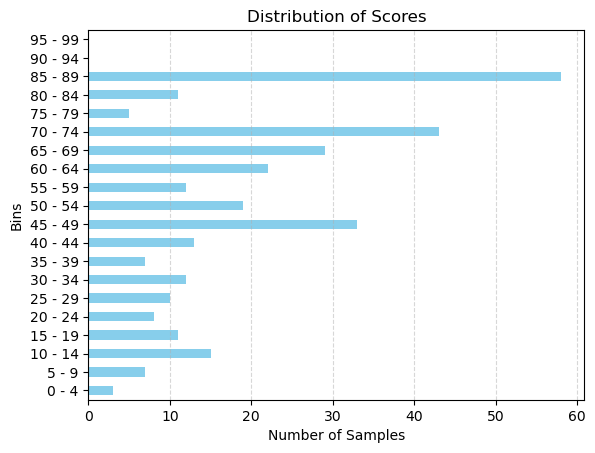

In [12]:
bins = np.arange(0,105,5)
labels = [f'{i} - {i+4}' for i in range(0,100,5)]
(pd.cut(df1['score']*100, bins, labels=labels)).value_counts().sort_index().plot(kind = 'barh', color='skyblue')

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlabel('Number of Samples')
plt.ylabel('Bins')
plt.title('Distribution of Scores')
plt.show()

## Percentage of Records with Scores >=65% Out of The Total Records

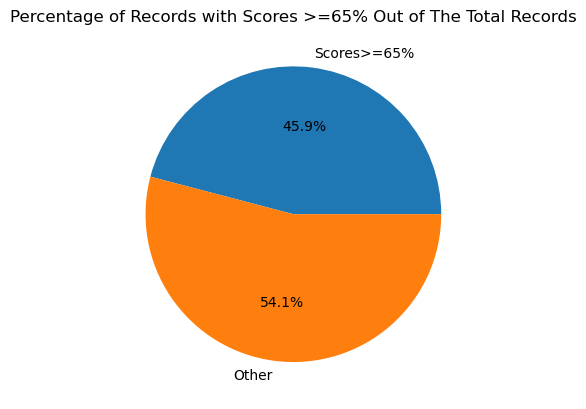

After results observation, we notice that records with score equal to or bigger than 65%
are most of the times true in terms of finding the most similar sentence.
Here we find that the percentage of these records with score equal to or more than 65% is 45.9% out of the total records.


In [13]:
total_records = len(df1) # 318
high_score_records = len(df1[df1['score']*100>=65]) # 146

high_score_percentage = (high_score_records*100)/total_records # 45.9%
other_percentage = 100 - high_score_percentage # 54.1%

values = [high_score_percentage, other_percentage]
labels = ['Scores>=65%', 'Other']
plt.pie(values, labels = labels, autopct='%1.1f%%')
plt.title('Percentage of Records with Scores >=65% Out of The Total Records')
plt.show()

print('After results observation, we notice that records with score equal to or bigger than 65%\n'+
      'are most of the times true in terms of finding the most similar sentence.'+
      '\nHere we find that the percentage of these records with score equal to or more than 65% is 45.9% '+
      'out of the total records.')

## Percentage of Records with Scores >=65% Against Percentage of Not Null Records in Expected Part Text

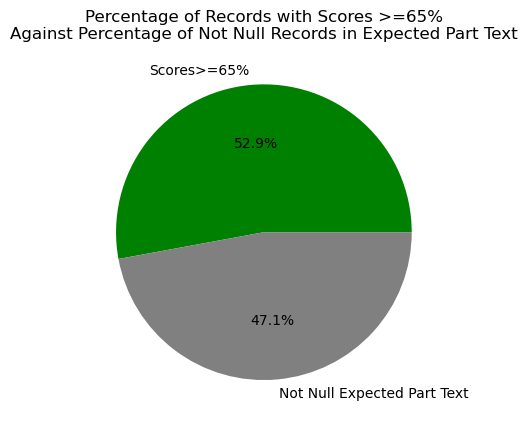

We notice that the percentage of records that have score equal to or bigger than 65%
is bigger than the percentage of not null records in expected_part_text column.


In [14]:
total_records = len(df1) # 318
high_score_records = len(df1[df1['score']*100>=65]) # 146
not_null_text = df1['extracted_part_text'].notnull().sum() # 130

high_score_percentage = (high_score_records*100)/total_records # 52.9%
not_null_percentage = (not_null_text*100)/total_records # 47.1

values = [high_score_percentage, not_null_percentage]
labels = ['Scores>=65%', 'Not Null Expected Part Text']
plt.pie(values, labels = labels, autopct='%1.1f%%', colors=['green','gray'])
plt.title('Percentage of Records with Scores >=65%\nAgainst Percentage of Not Null Records in Expected Part Text')
plt.show()

print('We notice that the percentage of records that have score equal to or bigger than 65%\n'+
      'is bigger than the percentage of not null records in expected_part_text column.')

## Fine-Tuning 

In [ ]:
def evaluating(path, testing_exSentenceTransformertenceTransformerples):

    model = SentenceTransformer(path)
    evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(testing_examples)
    return evaluator(model)

In [64]:
def fit(df, column_name, model_path, filter_records, epochs=5, threshold=0.65):
    """
    Fits a text similarity model using filtered or unfiltered data based on specified conditions and evaluates it.

    The function processes the dataframe using a Sentence Transformer model to find similarities, then filters
    records based on the score threshold if required. It creates training and testing datasets, configures data loaders,
    defines a loss function, and sets up an evaluator for cosine similarity. The model is trained with these configurations
    over specified epochs and periodically evaluated.

    Parameters:
    - df (DataFrame): DataFrame containing text, tokenized_sentences, and label column.
    - column_name (str): The column of text to be used for training ('text' or 'tokenized_sentences').
    - model_path (str): The path or name of the model to load.
    - filter_records (bool): If True, filters examples where the similarity score is equal to or above the threshold.
    - epochs (int, optional): Number of training epochs. Default is 5.
    - threshold (float, optional): The similarity score threshold used to filter records. Default is 0.65.

    """
    model, df = get_similarities(df, model_path)
    # InputExample is used to create instances that represent the data
    # each instance consists of a pair of texts and a label
    if column_name == 'text':
        if filter_records == False:
            examples = [InputExample(texts=[row[column_name], row['label']], label=row['score']) for _, row in df.iterrows()]
        else:
            examples = [InputExample(texts=[row[column_name], row['label']], label=row['score']) for _, row in df.iterrows()
                       if row['score']>=threshold]
    elif column_name == 'tokenized_sentences':
        if filter_records == False:
            examples = [InputExample(texts=[' '.join(row[column_name]), row['label']], label=row['score']) for _, row in df.iterrows()]
        else:
            examples = [InputExample(texts=[' '.join(row[column_name]), row['label']], label=row['score']) for _, row in df.iterrows()
                       if row['score']>=threshold]

    training_examples, testing_examples = train_test_split(examples, test_size=0.2, train_size=0.8, random_state=42)
    # Dataloader organizes the data into batches for efficient training
    # collate_fn uses a custom collation function that pairs texts for training ensuring batches are created
    # from texts of similar lengths to maximize the training efficeincy
    training_dataloader = DataLoader(training_examples, batch_size=16, shuffle= True, collate_fn=model.smart_batching_collate)
    # EmbeddingSimilarityEvaluator is used to evaulate the cosine similarity between embeddings generated
    # by the model for the test set
    evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(testing_examples)

    training_loss = losses.CosineSimilarityLoss(model)

    total_steps = (len(training_examples)/training_dataloader.batch_size)*epochs

    model.fit(train_objectives=[(training_dataloader, training_loss)],
              evaluator=evaluator,
              epochs=epochs,
              evaluation_steps=total_steps/epochs, # 64 total steps for the model/4 epochs = 16 step per epoch
              output_path=f'fine_tuned_model_{column_name}_Filtering_{filter_records}')

    eval_score = evaluating(path, testing_examples)
    return eval_score

eval_score_text_no = fit(df, 'text', './distiluse-base-multilingual-cased-v1', False)

Model was loaded from local files successfully.
0:09:00.231014


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

## Fine Tuning on tokenized_sentences Column

In [65]:
eval_score_tokenized_no = fit(df, 'tokenized_sentences', './distiluse-base-multilingual-cased-v1', False)

Model was loaded from local files successfully.
0:09:33.017351


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

Iteration:   0%|          | 0/16 [00:00<?, ?it/s]

## Previous Results (Default Model) <br> VS. Results of Fine-Tuned Model Using text Column <br> VS. Results of Fine-Tuned Model Using tokenized_sentences Column <br> Depending on EmbeddingSimilarityEvaluator (No Records Filtering)

In [66]:
examples = [InputExample(texts=[row['text'], row['label']], label=row['score']) for _, row in df.iterrows()]
training_examples, testing_examples = train_test_split(examples, test_size=0.2, train_size=0.8, random_state=42)
evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(testing_examples)

normal_model = evaluator(SentenceTransformer('distiluse-base-multilingual-cased-v1'))

fine_tuned_model_text = evaluator(SentenceTransformer('fine_tuned_model_text_Filtering_False'))


examples = [InputExample(texts=[' '.join(row['tokenized_sentences']), row['label']], label=row['score']) for _, row in df.iterrows()]
training_examples, testing_examples = train_test_split(examples, test_size=0.2, train_size=0.8, random_state=42)
evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(testing_examples)

fine_tuned_model_tokenized_sentences = evaluator(SentenceTransformer('fine_tuned_model_tokenized_sentences_Filtering_False'))

print(f"""The following results depend on the EmbeddingSimilarityEvaluator that is set up during training on testing_examples.\n
Model's score before fine-tuning: {normal_model:.2%}.\n
Model's score after fine-tuning and using text column: {fine_tuned_model_text:.2%}\n
Model's score after fine-tuning and using tokenized_sentences column: {fine_tuned_model_tokenized_sentences:.2%}""")

The following results depend on the EmbeddingSimilarityEvaluator that is set up during training on testing_examples.

Model's score before fine-tuning: 46.23%.

Model's score after fine-tuning and using text column: 51.40%

Model's score after fine-tuning and using tokenized_sentences column: 51.48%


## Fine Tuning on Records with Similarity >= 65% 

In [67]:
eval_score_text_yes = fit(df, 'text', './distiluse-base-multilingual-cased-v1', True)

Model was loaded from local files successfully.
0:09:33.245043


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

In [68]:
eval_score_tokenized_yes = fit(df, 'tokenized_sentences', './distiluse-base-multilingual-cased-v1', True)

Model was loaded from local files successfully.
0:09:28.910345


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

## Previous Results (Default Model) <br> VS. Results of Fine-Tuned Model Using text Column <br> VS. Results of Fine-Tuned Model Using tokenized_sentences Column <br> Depending on EmbeddingSimilarityEvaluator (Records Filtering)

In [69]:
examples = [InputExample(texts=[row['text'], row['label']], label=row['score']) for _, row in df.iterrows()
           if row['score']>=0.65]

training_examples, testing_examples = train_test_split(examples, test_size=0.2, train_size=0.8, random_state=42)
evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(testing_examples)

normal_model = evaluator(SentenceTransformer('distiluse-base-multilingual-cased-v1'))

fine_tuned_model_text = evaluator(SentenceTransformer('fine_tuned_model_text_Filtering_True'))


examples = [InputExample(texts=[' '.join(row['tokenized_sentences']), row['label']], label=row['score']) for _, row in df.iterrows()
           if row['score']>=0.65]

training_examples, testing_examples = train_test_split(examples, test_size=0.2, train_size=0.8, random_state=42)
evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(testing_examples)

fine_tuned_model_tokenized_sentences = evaluator(SentenceTransformer('fine_tuned_model_tokenized_sentences_Filtering_True'))

print(f"""The following results depend on the EmbeddingSimilarityEvaluator that is set up during training on testing_examples.\n
Model's score before fine-tuning with records filtering: {normal_model:.2%}.\n
Model's score after fine-tuning and using text column  with records filtering: {fine_tuned_model_text:.2%}\n
Model's score after fine-tuning and using tokenized_sentences column with records filtering: {fine_tuned_model_tokenized_sentences:.2%}""")

The following results depend on the EmbeddingSimilarityEvaluator that is set up during training on testing_examples.

Model's score before fine-tuning with records filtering: -35.57%.

Model's score after fine-tuning and using text column  with records filtering: -35.25%

Model's score after fine-tuning and using tokenized_sentences column with records filtering: -35.25%


### Among all the models, model X was chosen for forecasting since it gots the heighest performance on EmbeddingSimilarityEvaluator 

In [70]:
_, fine_tuned_df = get_similarities(df, 'fine_tuned_model_text_Filtering_False')

Model was loaded from local files successfully.
0:09:13.760896


## Distribution of Similarity Score Among The Dataset 

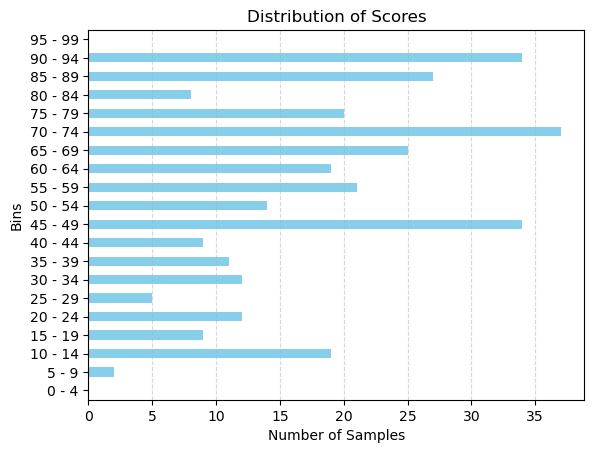

In [71]:
bins = np.arange(0,105,5)
labels = [f'{i} - {i+4}' for i in range(0,100,5)]
(pd.cut(fine_tuned_df['score']*100, bins, labels=labels)).value_counts().sort_index().plot(kind = 'barh', color='skyblue')

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlabel('Number of Samples')
plt.ylabel('Bins')
plt.title('Distribution of Scores')
plt.show()

## Percentage of Records with Scores >=65% Out of The Total Records

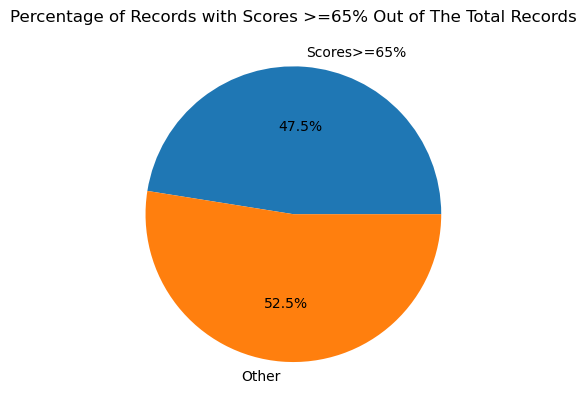

After results observation, we notice that the model performed better after fine-tuning on percentage of recordswith score equal to or bigger than 65%.

Here we find that the percentage of these records with score equal to or more than 65% is 47.2%
knowing that it was 45.9% out of the total records.


In [74]:
total_records = len(fine_tuned_df) # 318

high_score_records = len(fine_tuned_df[fine_tuned_df['score']*100>=65]) # 150

high_score_percentage = (high_score_records*100)/total_records # 47.5%
other_percentage = 100 - high_score_percentage # 52.5%

values = [high_score_percentage, other_percentage]
labels = ['Scores>=65%', 'Other']
plt.pie(values, labels = labels, autopct='%1.1f%%')
plt.title('Percentage of Records with Scores >=65% Out of The Total Records')
plt.show()

print('After results observation, we notice that the model performed better after fine-tuning on percentage of records'+
      'with score equal to or bigger than 65%.\n'+
      '\nHere we find that the percentage of these records with score equal to or more than 65% is 47.5%\nknowing that it was 45.9% '+
      'out of the total records.')

## Percentage of Records with Scores >=65% Against Percentage of Not Null Records in Expected Part Text

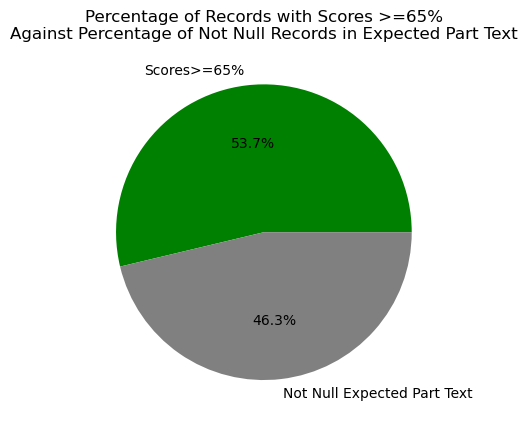

We notice that the percentage of records that have score equal to or bigger than 65%
is bigger than the percentage of not null records in expected_part_text column.


In [73]:
total_records = len(fine_tuned_df) # 318
high_score_records = len(fine_tuned_df[fine_tuned_df['score']*100>=65]) # 150
not_null_text = fine_tuned_df['extracted_part_text'].notnull().sum() # 130

high_score_percentage = (high_score_records*100)/total_records # 53.6%
not_null_percentage = (not_null_text*100)/total_records # 46.4%

values = [high_score_percentage, not_null_percentage]
labels = ['Scores>=65%', 'Not Null Expected Part Text']
plt.pie(values, labels = labels, autopct='%1.1f%%', colors=['green','gray'])
plt.title('Percentage of Records with Scores >=65%\nAgainst Percentage of Not Null Records in Expected Part Text')
plt.show()

print('We notice that the percentage of records that have score equal to or bigger than 65%\n'+
      'is bigger than the percentage of not null records in expected_part_text column.')